In [1]:
import numpy as np
import pandas as pd
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.alamopy import AlamoTrainer, AlamoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import surrogate_parity

### 1. Using the ALAMO wrapper provided by IDAES

In [2]:
df = pd.read_csv('C:/Users/sbugo/surr-vs-imp/surrogate-vs-implicit/svi/Gibbs_reactor/data_gibbs.csv')

df = df.rename(columns={'T_in (K)': 'Tin', 'P_in (Pa)': 'Pin','Heat Duty (W)': 'HeatDuty',
                        'F_out (mol/s)': 'Fout','T_out (K)': 'Tout'})

df = df.drop('Unnamed: 0', axis=1)  
df = df.drop('F_in (mol/s)', axis=1)  

# Recall that the input data to the surrogate models is methane  
# conversion and inlet temperature and pressure to the reactor. 
input_data = df.iloc[:, :3]

# Recall that the output data of the surrogate models is outlet  
# temperature and flow rate, heat duty, and molar compositions of
# H2, H2O, CO, CO2, CH4
output_data = df.iloc[:, 3:]

# Split training and validation data
input_labels = input_data.columns
output_labels = output_data.columns

n_data = df[input_labels[0]].size
data_training, data_validation = split_training_validation(df, 0.8, seed=n_data)

In [3]:
trainer = AlamoTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_training,
)

trainer.config.constant = True
trainer.config.linfcns = True
trainer.config.monomialpower = [2]

success, alm_surr, msg = trainer.train_surrogate()

model = alm_surr.save_to_file("alamo_surrogate.json", overwrite=True)

surrogate_expressions = trainer._results["Model"]

surrogate_expressions

 ***************************************************************************
 ALAMO version 2023.2.13. Built: WIN-64 Mon Feb 13 21:30:56 EST 2023

 If you use this software, please cite:
 Cozad, A., N. V. Sahinidis and D. C. Miller,
 Automatic Learning of Algebraic Models for Optimization,
 AIChE Journal, 60, 2211-2227, 2014.

 ALAMO is powered by the BARON software from http://www.minlp.com/
 ***************************************************************************
 Licensee: Sergio Bugosen at Carnegie Mellon University, sbugosen@andrew.cmu.edu
 .
 ***************************************************************************
 Reading input data
 Checking input consistency and initializing data structures
 
 Step 0: Initializing data set
 User provided an initial data set of 399 data points
 We will sample no more data points at this stage
 ***************************************************************************
 Iteration 1 (Approx. elapsed time 0.0 s)
 
 Step 1: Model building usi

{'HeatDuty': ' HeatDuty == 1.4678106229046550268436 * Pin + 7492679.3190992288291454 * Conversion - 10.499696945466528319457 * Tin**2 + 11325957.723421573638916 * Conversion**2 + 7880427.4645758615806699',
 'Fout': ' Fout == 0.62914722556701180842874E-018 * Pin + 149.99999999999982946974 * Conversion - 0.41157491543752020659484E-018 * Tin**2 + 309.00926962920010510061',
 'Tout': ' Tout == 0.79190860347839106005673E-004 * Pin - 342.53289756267298571402 * Conversion + 529.73772844731888653769 * Conversion**2 + 895.46814081893501224840',
 'H2': ' H2 ==  - 0.84912153542841269357851E-008 * Pin + 0.76083989362586657012599 * Conversion - 0.27196209848360641814224 * Conversion**2 + 0.58569374065669976836546E-001',
 'H2O': ' H2O == 0.84937212910803231779427E-008 * Pin - 0.66294089727314642335188 * Conversion + 0.24910123060595365518388 * Conversion**2 + 0.70291914195233540230134',
 'CO2': ' CO2 ==  - 0.85067012322742221474015E-008 * Pin + 0.15585579511383079731601 * Conversion - 0.1306893371742

In [4]:
input_labels = trainer._input_labels
output_labels = trainer._output_labels

input_bounds = {"Tin": (500.0588312036811, 699.8181581857999), 
                "Pin": (801730.848810735, 1199775.6795772058), 
                "Conversion": (0.5015504320165675, 0.9797294341336952)}

alm_surr = AlamoSurrogate(
    surrogate_expressions, input_labels, output_labels, input_bounds
)

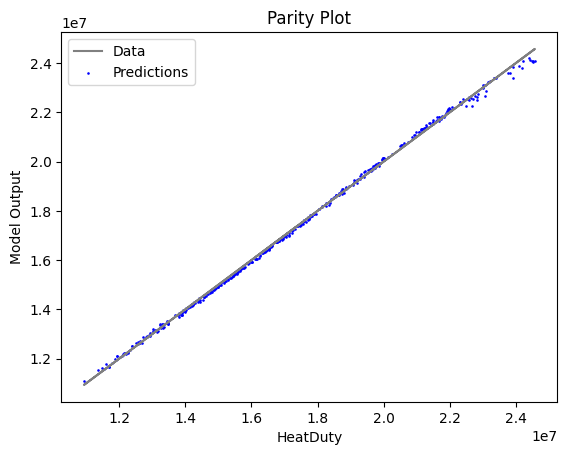

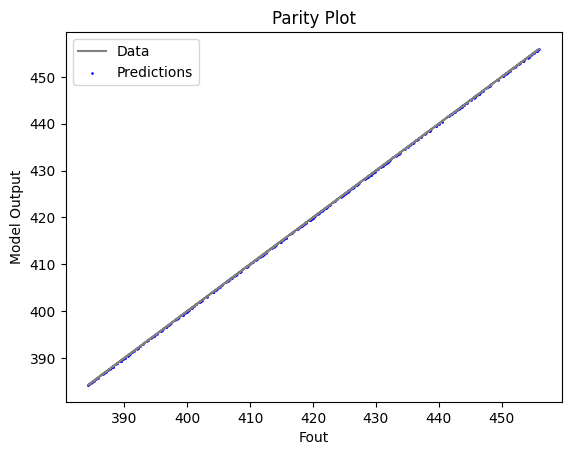

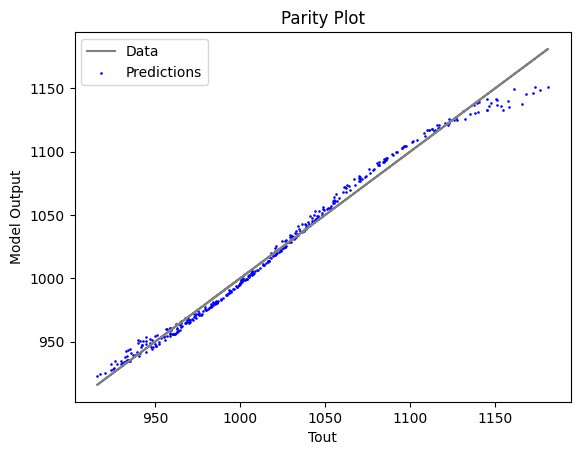

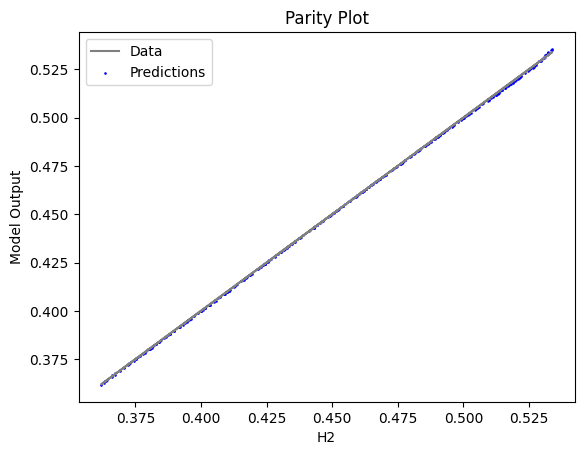

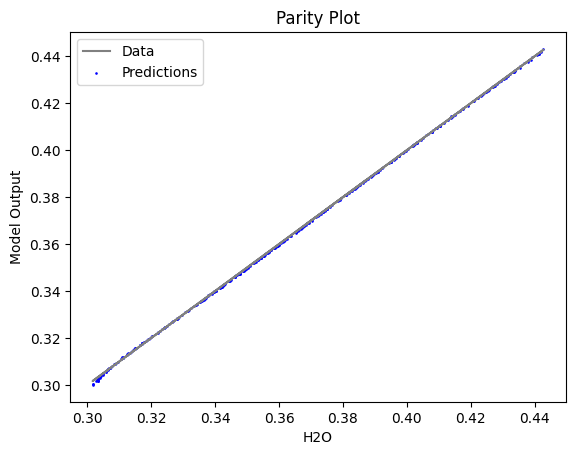

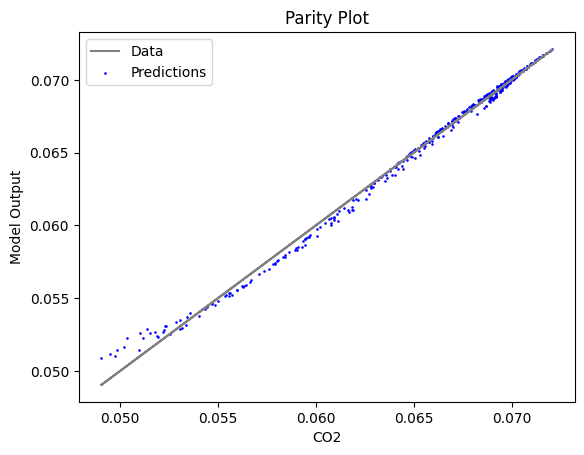

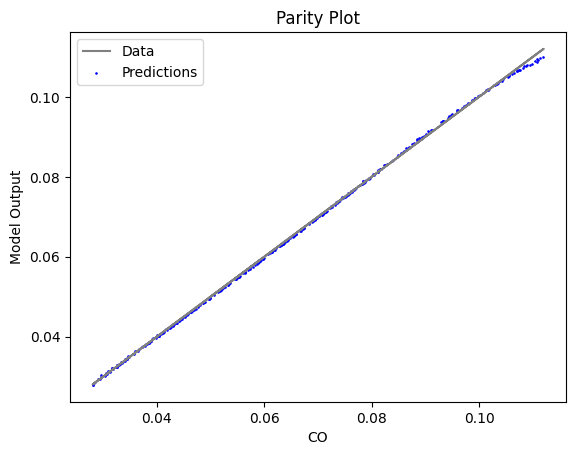

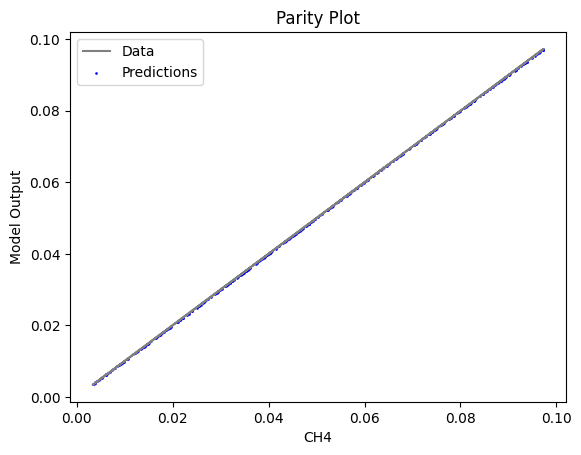

In [5]:
# Check if predictions by ALAMO match the real values
surrogate_parity(alm_surr, data_training)

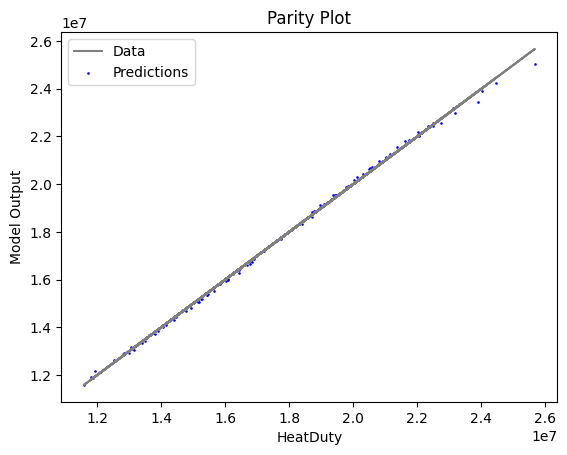

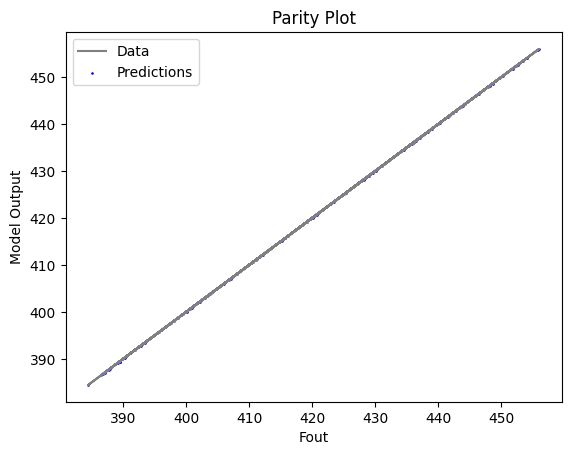

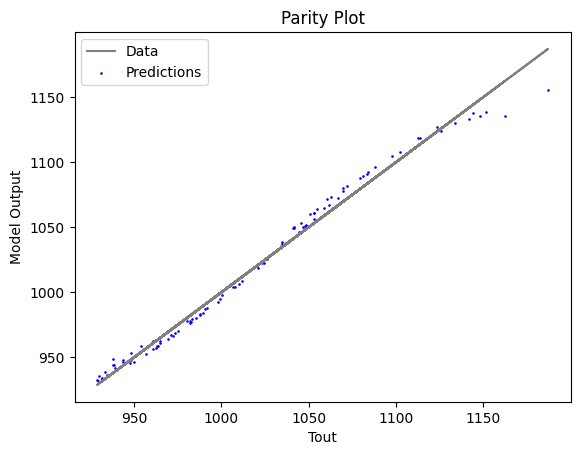

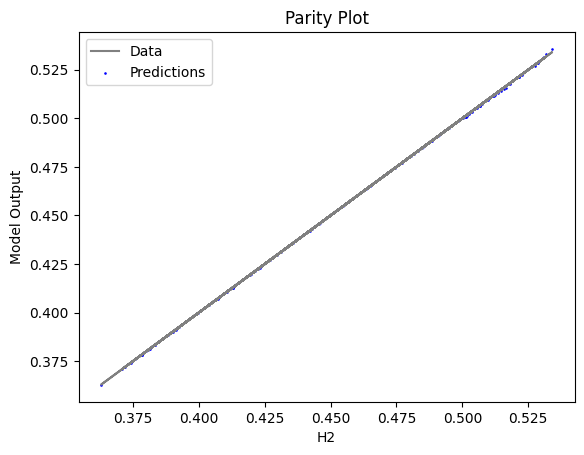

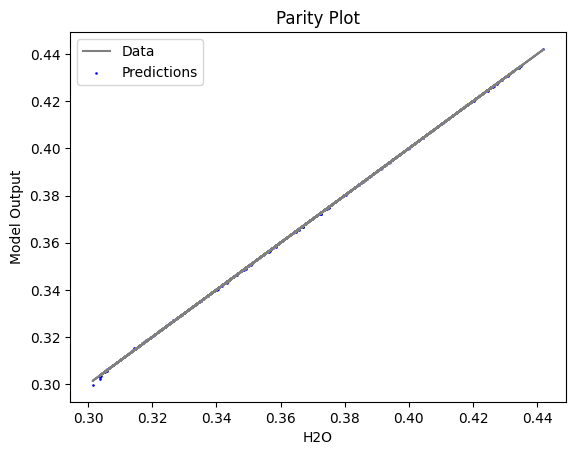

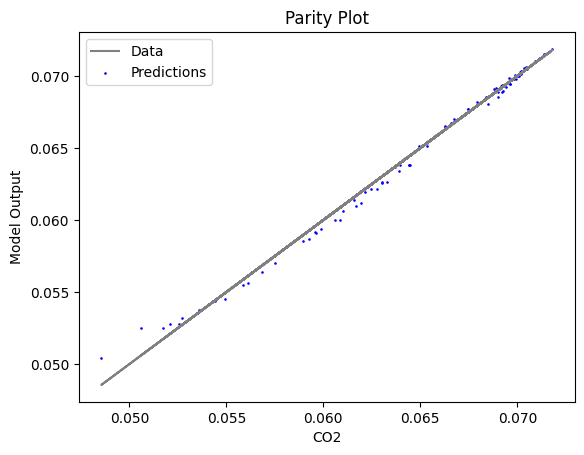

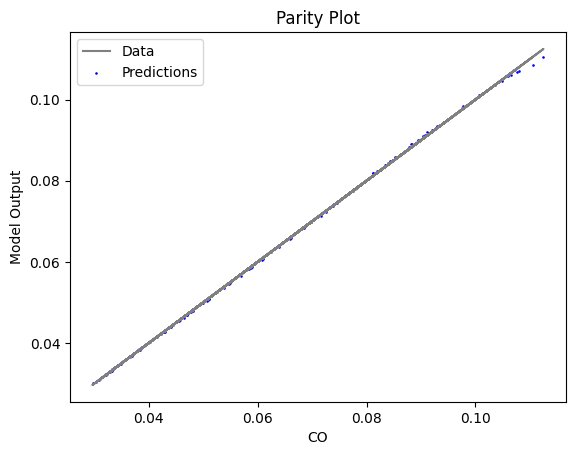

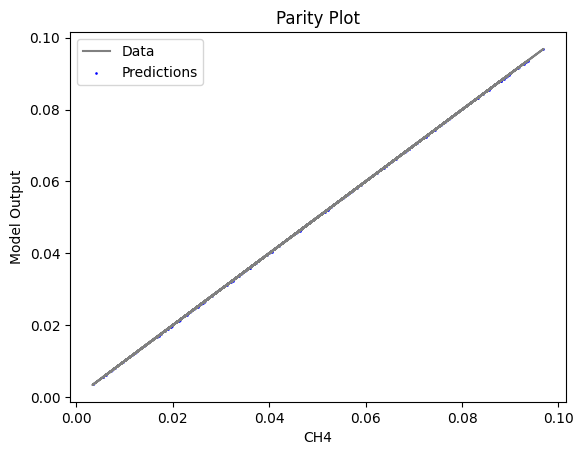

In [6]:
# Check if the ALAMO surrogates correctly predict unseen data.
surrogate_parity(alm_surr, data_validation)

### 2. Replacing the Gibbs Reactor with the ALAMO Surrogate Model

We can construct the flowsheet shown below now that we have the surrogate models for the Gibbs Reactor.

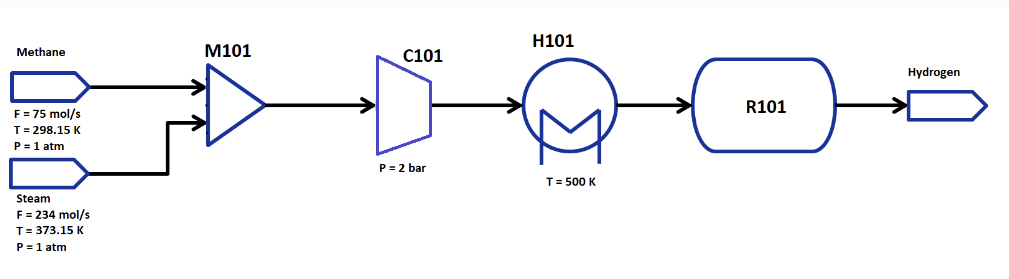

In [7]:
from pyomo.environ import (
    Constraint,
    Var,
    ConcreteModel,
    Expression,
    Objective,
    TransformationFactory,
    value,
    Block,
    units as pyunits,
)
from pyomo.network import Arc
from pyomo.network import Port

from idaes.core import FlowsheetBlock
from idaes.models.properties.modular_properties import GenericParameterBlock
from idaes.models.unit_models import (
    Feed,
    Mixer,
    Compressor,
    Heater,
    Product,
)
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state
from idaes.models_extra.power_generation.properties.natural_gas_PR import get_prop

In [8]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
thermo_props_config_dict = get_prop(components=["CH4", "H2O", "H2", "CO", "CO2"])
m.fs.thermo_params = GenericParameterBlock(**thermo_props_config_dict)

m.fs.CH4 = Feed(property_package=m.fs.thermo_params)

m.fs.H2O = Feed(property_package=m.fs.thermo_params)

m.fs.PROD = Product(property_package=m.fs.thermo_params)

m.fs.M101 = Mixer(property_package=m.fs.thermo_params, inlet_list=["methane_feed", "steam_feed"])

m.fs.H101 = Heater(
    property_package=m.fs.thermo_params,
    has_pressure_change=False,
    has_phase_equilibrium=False,
)

m.fs.C101 = Compressor(property_package=m.fs.thermo_params)

m.fs.R101_heat_duty = Var(doc="Gibbs Reactor Heat Duty (W)")

m.fs.R101 = SurrogateBlock() # define the Surrogate Block for the Gibbs Reactor
m.fs.R101.conversion = Var(bounds=(0, 1), units=pyunits.dimensionless)  

# define the inputs to the surrogate models
inputs = [m.fs.H101.outlet.temperature, m.fs.H101.outlet.pressure, m.fs.R101.conversion]

# define the outputs of the surrogate models
outputs = [m.fs.R101_heat_duty, m.fs.PROD.flow_mol, m.fs.PROD.temperature, m.fs.PROD.mole_frac_comp[0, "H2"],
           m.fs.PROD.mole_frac_comp[0, "H2O"], m.fs.PROD.mole_frac_comp[0, "CO2"], 
           m.fs.PROD.mole_frac_comp[0, "CO"], m.fs.PROD.mole_frac_comp[0, "CH4"]]

# build the surrogate for the Gibbs Reactor using the JSON file obtained before
surrogate = AlamoSurrogate.load_from_file("alamo_surrogate.json")
m.fs.R101.build_model(surrogate, input_vars=inputs, output_vars=outputs)

In [9]:
# Now we connect the unit models using arcs
m.fs.s01 = Arc(source=m.fs.CH4.outlet, destination=m.fs.M101.methane_feed)
m.fs.s02 = Arc(source=m.fs.H2O.outlet, destination=m.fs.M101.steam_feed)
m.fs.s03 = Arc(source=m.fs.M101.outlet, destination=m.fs.C101.inlet)
m.fs.s04 = Arc(source=m.fs.C101.outlet, destination=m.fs.H101.inlet)
m.fs.s05 = Arc(source=m.fs.H101.outlet, destination=m.fs.R101.inlet)
m.fs.s06 = Arc(source=m.fs.R101.outlet, destination=m.fs.PROD.inlet)

AttributeError: '_ScalarSurrogateBlock' object has no attribute 'inlet'